# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.1: LB = ??? CV = 0.444957
- modelo: Catboost (com algumas otimizações)
- features engineering: gerado através do Auto_ViML

Versão 1.0.2: LB = ??? CV = 0.4119785694
- modelo: Catboost (com algumas otimizações)
- features engineering: Kernel_Feature_Engineering_v.1.0.0

# Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [9]:
# Importa os pacotes de algoritmos
from catboost import Pool, CatBoostClassifier, cv

# Importa pacotes do sklearn
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder


# Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino_new.csv....')
        train = pd.read_csv('../dataset/dataset_treino_new.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste_new.csv....')
        test = pd.read_csv('../dataset/dataset_teste_new.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino_new.csv....
dataset_treino.csv tem 114321 linhas and 184 colunas
Carregando arquivo dataset_teste_new.csv....
dataset_teste.csv tem 114393 linhas and 183 colunas


In [5]:
df = train.append(test)

In [6]:
df = df.drop(columns = ['1'], axis = 1)

In [7]:
# Verificar a quantidade de features numericas e categoricas

numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  164
Number of Categorical features:  19


In [10]:
# Transformando as features categorias com LabelEncoder
le = LabelEncoder()

for i, col in enumerate(df):
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))

In [11]:
scaler = StandardScaler()
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'float64' and c != 'target':
        df[c] = scaler.fit_transform(df[c].values.reshape(-1, 1))

In [12]:
df.head()

,ID,grp_1,grp_10,grp_11,grp_12,grp_2,grp_3,grp_4,grp_5,grp_6,grp_7,grp_8,grp_9,ica_1,ica_10,ica_11,ica_12,ica_2,ica_3,ica_4,ica_5,ica_6,ica_7,ica_8,ica_9,pca_1,pca_10,pca_11,pca_12,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,srp_1,srp_10,srp_11,srp_12,srp_2,srp_3,srp_4,srp_5,srp_6,srp_7,srp_8,srp_9,target,tsvd_1,tsvd_10,tsvd_11,tsvd_12,tsvd_2,tsvd_3,tsvd_4,tsvd_5,tsvd_6,tsvd_7,tsvd_8,tsvd_9,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119 v123,v119 v48,v119 v85,v119^2,v119_x,v119_y,v120,v121,v122,v123 v48,v123 v85,v123^2,v123_x,v123_y,v124,v125,v126,v127,v129,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v26,v27,v28,v29,v3,v30,v31,v35,v36,v37,v39,v4,v40,v42,v44,v45,v47,v48 v85,v48^2,v48_x,v48_y,v5,v50,v51,v52,v56,v57,v58,v59,v6,v61,v62 v119,v62 v123,v62 v48,v62 v85,v62^2,v62_x,v62_y,v66,v68,v69,v7,v70,v71,v72,v74,v75,v78,v79,v80,v81,v82,v84,v85^2,v85_x,v85_y,v86,v88,v9,v90,v91,v92,v93,v94,v98,v99
0,3,0.2850,-0.5340,0.7369,-0.3409,0.4189,-0.4901,-0.2476,0.5990,-0.5500,-1.0831,-0.5510,0.5442,-1.2994,-0.5487,0.0462,0.0918,-0.3198,0.8232,-0.5992,-0.0509,1.0963,-0.2704,-0.1532,-0.4241,-0.4764,-0.1160,0.8402,-0.5990,0.0533,-0.0563,-1.2308,-0.1335,0.9989,0.4216,0.7842,-0.0250,0.2290,-0.2778,-0.3061,-0.5739,-0.3400,-0.5756,0.5034,-0.0579,3.6872,0.1301,-0.0633,0.0588,1.0000,-0.4368,0.1122,0.3718,0.8532,-0.4868,-0.1186,0.3664,-1.1441,-0.1477,1.0393,0.4216,0.7533,-0.2736,-0.9882,1.1958,0.9235,0.0415,-0.9135,-1.5088,-0.4096,0.3000,4,0.4394,0.0772,1.6324,1,-2.5041,14,37,0.7880,-5.3735,-0.6145,-0.5820,-1.5587,-0.3782,-0.6213,-0.4859,-0.3233,-0.7362,-0.7365,-0.3030,-1.7502,0.8971,-0.5052,-0.5311,-0.3723,-0.6058,-0.6061,-0.3371,21,0.4139,-0.0054,0,-1.1680,1.3858,-0.3188,-1.2441,2.7146,-0.0260,-1.4597,-0.5138,0.6601,1.1166,0.6552,21416,-0.2008,2,-0.3177,1.0914,-2.2218,0.6550,2,2,0,0.2759,-1.2270,-0.6016,1.7123,-0.2882,-0.8690,-0.3001,-0.1805,0.4548,2,-0.7699,-0.2459,-0.1911,-0.1909,-0.5106,-0.5198,0.0571,6,90,-0.2007,-1.1651,0.2144,0.3898,0.6599,-0.5765,-0.4068,-0.0853,-0.4846,-0.2488,1,-0.0441,2,-1.4891,5.3732,1.5934,-0.3296,5,1,1,3,-3.4438,4,1.0438,0.0833,1.2151,-0.3209,-0.7130,-0.9485,-0.9515,-0.9243,1.8558,0.6585,-0.4215,0,-0.6182,0.3390,-0.4463,0.6921,-0.1501
1,4,0.2473,-0.2156,0.7257,-0.2332,0.3612,-0.0703,-0.1008,0.1772,-0.1120,0.4818,-0.1336,0.1653,-0.2075,0.4652,0.1989,-1.3864,0.1256,-1.3524,-0.1584,-0.0283,-0.0498,0.2388,-0.0701,0.6590,-0.2567,0.4856,-0.7588,-0.1000,0.1888,-0.0224,-0.0518,1.3082,0.1851,-0.1856,-1.3013,0.4258,0.2958,0.8013,-0.3029,-0.0043,-0.2377,-0.1149,0.2234,0.2567,0.1184,0.2882,-0.2186,-0.3754,1.0000,-0.1950,0.2275,-0.7382,-0.5432,-0.3029,0.0391,-0.0090,-0.0283,1.3026,0.2065,-0.1855,-1.3389,-0.1091,-0.4080,0.2551,-0.0747,-0.1728,-0.1063,-0.1119,0.4440,0.0775,1,-0.3611,0.1877,0.0482,0,-0.1295,20,17,-1.2488,-0.0292,-0.0770,0.8747,-0.0858,-0.2648,-0.2859,-0.2808,-0.2816,-0.2903,-0.2905,-0.1509,-0.1677,-0.0314,-0.2309,-0.2467,-0.2425,-0.2281,-0.2284,0.0032,6,-0.0854,-0.1278,0,-0.2150,-0.0964,-0.3188,-0.0912,0.0061,-0.1064,-0.0850,-0.1096,-0.1042,0.1691,-0.2550,9923,-0.2008,2,-0.0652,-0.0608,-0.0162,0.0507,2,2,0,-0.0289,0.5832,-0.1360,-0.2661,0.0419,1.2110,0.0026,-0.0014,0.0076,4,-0.1530,-0.1076,-0.0457,-0.0454,0.3127,-0.1086,-0.0196,6,106,-0.0121,-0.2546,-0.0141,-0.0284,0.1743,0.0814,0.6549,1.3366,1.0440,1.1172,2,1.3932,0,0.2312,0.0267,-0.0385,-0.1772,5,2,1,3,-0.0027,3,-0.0826,-0.0645,-0.5607,-0.1471,-0.2280,-0.1145,-0.1173,-0.0992,-0.1171,0.0086,0.0103,1,-0.1159,-0.0766,-0.0976,0.3674,-0.0220
2,5,0.2491,-0.5521,0.7422,-0.2849,0.5352,-0.3467,1.1777,0.2024,-0.1420,-0.0214,-0.1806,-0.5655,-1.0570,-3.1771,0.0173,0.0349,-0.0686,-0.9372,-0.2103,-1.2578,0.2076,-0.2718,-0.0916,-0.2618,-0.3770,-2.7029,0.0794,-0.2399,0.5678,0.0953,-0.7217,-0.1708,1.4885,-0.1030,-0.0402,1.8146,0.3332,1.6291,-0.2397,-0.3904,-0.4470,-0.0409,0.3624,0.0753,-2.7300,-2.5286,-0.4955,-0.5021,1.0000,-0.2388,0.7637,2.7233,-0.8274,-0.4933,0.3941,-0.2710,-0.8211,-0.1746,1.6794,-0.

# Feature Engineering

# Algoritmo Catboost


In [13]:
treino = df[df['target'].notnull()]
teste = df[df['target'].isnull()]
    
# Separando features preditoras e target
train_x = treino.drop(['ID','target'], axis=1)
train_y = treino['target']

In [15]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, train_size=0.99, random_state=42)

model = CatBoostClassifier(iterations=1500, 
                           learning_rate=0.01, 
                           l2_leaf_reg=3.5, 
                           depth=8, 
                           rsm=0.98, 
                           loss_function= 'Logloss', 
                           eval_metric='Logloss',
                           use_best_model=True,
                           random_seed=42)

#now just to make the model to fit the data
model.fit(X_train, y_train, cat_features=categorical_feats, eval_set=(X_val, y_val))

0:	learn: 0.6884991	test: 0.6882613	best: 0.6882613 (0)	total: 1.22s	remaining: 30m 28s
1:	learn: 0.6839546	test: 0.6834425	best: 0.6834425 (1)	total: 2.32s	remaining: 28m 56s
2:	learn: 0.6794528	test: 0.6785821	best: 0.6785821 (2)	total: 3.44s	remaining: 28m 38s
3:	learn: 0.6748950	test: 0.6736099	best: 0.6736099 (3)	total: 4.5s	remaining: 28m 3s
4:	learn: 0.6702643	test: 0.6686527	best: 0.6686527 (4)	total: 5.53s	remaining: 27m 32s
5:	learn: 0.6659679	test: 0.6640866	best: 0.6640866 (5)	total: 6.6s	remaining: 27m 22s
6:	learn: 0.6617249	test: 0.6594743	best: 0.6594743 (6)	total: 7.57s	remaining: 26m 54s
7:	learn: 0.6576729	test: 0.6551538	best: 0.6551538 (7)	total: 8.62s	remaining: 26m 48s
8:	learn: 0.6537837	test: 0.6510221	best: 0.6510221 (8)	total: 9.6s	remaining: 26m 30s
9:	learn: 0.6497591	test: 0.6467539	best: 0.6467539 (9)	total: 10.7s	remaining: 26m 36s
10:	learn: 0.6460701	test: 0.6427294	best: 0.6427294 (10)	total: 11.7s	remaining: 26m 19s
11:	learn: 0.6422775	test: 0.63873

92:	learn: 0.5063290	test: 0.4886763	best: 0.4886763 (92)	total: 1m 27s	remaining: 22m 5s
93:	learn: 0.5057186	test: 0.4879581	best: 0.4879581 (93)	total: 1m 28s	remaining: 22m 4s
94:	learn: 0.5050842	test: 0.4872187	best: 0.4872187 (94)	total: 1m 29s	remaining: 22m 3s
95:	learn: 0.5044793	test: 0.4864631	best: 0.4864631 (95)	total: 1m 30s	remaining: 22m 1s
96:	learn: 0.5039349	test: 0.4858515	best: 0.4858515 (96)	total: 1m 31s	remaining: 22m
97:	learn: 0.5034176	test: 0.4852441	best: 0.4852441 (97)	total: 1m 32s	remaining: 21m 59s
98:	learn: 0.5028436	test: 0.4846017	best: 0.4846017 (98)	total: 1m 33s	remaining: 21m 59s
99:	learn: 0.5023215	test: 0.4839857	best: 0.4839857 (99)	total: 1m 34s	remaining: 21m 57s
100:	learn: 0.5017950	test: 0.4833610	best: 0.4833610 (100)	total: 1m 35s	remaining: 21m 57s
101:	learn: 0.5012523	test: 0.4827835	best: 0.4827835 (101)	total: 1m 35s	remaining: 21m 54s
102:	learn: 0.5008790	test: 0.4823271	best: 0.4823271 (102)	total: 1m 36s	remaining: 21m 45s
1

181:	learn: 0.4784533	test: 0.4547577	best: 0.4547577 (181)	total: 2m 48s	remaining: 20m 17s
182:	learn: 0.4782864	test: 0.4545341	best: 0.4545341 (182)	total: 2m 48s	remaining: 20m 16s
183:	learn: 0.4781124	test: 0.4543236	best: 0.4543236 (183)	total: 2m 50s	remaining: 20m 16s
184:	learn: 0.4779916	test: 0.4541578	best: 0.4541578 (184)	total: 2m 51s	remaining: 20m 15s
185:	learn: 0.4778511	test: 0.4539936	best: 0.4539936 (185)	total: 2m 51s	remaining: 20m 14s
186:	learn: 0.4777097	test: 0.4538153	best: 0.4538153 (186)	total: 2m 53s	remaining: 20m 14s
187:	learn: 0.4775910	test: 0.4536671	best: 0.4536671 (187)	total: 2m 54s	remaining: 20m 14s
188:	learn: 0.4774814	test: 0.4535372	best: 0.4535372 (188)	total: 2m 55s	remaining: 20m 14s
189:	learn: 0.4773363	test: 0.4533777	best: 0.4533777 (189)	total: 2m 56s	remaining: 20m 13s
190:	learn: 0.4772071	test: 0.4532103	best: 0.4532103 (190)	total: 2m 57s	remaining: 20m 13s
191:	learn: 0.4770726	test: 0.4530225	best: 0.4530225 (191)	total: 2m 

270:	learn: 0.4705428	test: 0.4447181	best: 0.4447181 (270)	total: 4m 11s	remaining: 19m 1s
271:	learn: 0.4704828	test: 0.4446527	best: 0.4446527 (271)	total: 4m 12s	remaining: 19m
272:	learn: 0.4703635	test: 0.4445012	best: 0.4445012 (272)	total: 4m 13s	remaining: 18m 59s
273:	learn: 0.4703247	test: 0.4444421	best: 0.4444421 (273)	total: 4m 14s	remaining: 18m 59s
274:	learn: 0.4702473	test: 0.4443583	best: 0.4443583 (274)	total: 4m 15s	remaining: 18m 58s
275:	learn: 0.4701990	test: 0.4442843	best: 0.4442843 (275)	total: 4m 16s	remaining: 18m 58s
276:	learn: 0.4701236	test: 0.4441666	best: 0.4441666 (276)	total: 4m 17s	remaining: 18m 57s
277:	learn: 0.4700764	test: 0.4441078	best: 0.4441078 (277)	total: 4m 18s	remaining: 18m 56s
278:	learn: 0.4700295	test: 0.4440794	best: 0.4440794 (278)	total: 4m 19s	remaining: 18m 55s
279:	learn: 0.4699800	test: 0.4440409	best: 0.4440409 (279)	total: 4m 20s	remaining: 18m 54s
280:	learn: 0.4699182	test: 0.4439892	best: 0.4439892 (280)	total: 4m 21s	r

359:	learn: 0.4629350	test: 0.4339432	best: 0.4339432 (359)	total: 5m 49s	remaining: 18m 26s
360:	learn: 0.4628834	test: 0.4338690	best: 0.4338690 (360)	total: 5m 50s	remaining: 18m 25s
361:	learn: 0.4627983	test: 0.4337457	best: 0.4337457 (361)	total: 5m 51s	remaining: 18m 25s
362:	learn: 0.4627430	test: 0.4336750	best: 0.4336750 (362)	total: 5m 52s	remaining: 18m 24s
363:	learn: 0.4626871	test: 0.4335973	best: 0.4335973 (363)	total: 5m 53s	remaining: 18m 23s
364:	learn: 0.4625902	test: 0.4334027	best: 0.4334027 (364)	total: 5m 54s	remaining: 18m 22s
365:	learn: 0.4625017	test: 0.4332128	best: 0.4332128 (365)	total: 5m 55s	remaining: 18m 21s
366:	learn: 0.4624082	test: 0.4330520	best: 0.4330520 (366)	total: 5m 56s	remaining: 18m 21s
367:	learn: 0.4623083	test: 0.4328522	best: 0.4328522 (367)	total: 5m 57s	remaining: 18m 21s
368:	learn: 0.4622342	test: 0.4327342	best: 0.4327342 (368)	total: 5m 59s	remaining: 18m 20s
369:	learn: 0.4621978	test: 0.4326858	best: 0.4326858 (369)	total: 6m	

448:	learn: 0.4584725	test: 0.4279839	best: 0.4279839 (448)	total: 7m 22s	remaining: 17m 15s
449:	learn: 0.4584479	test: 0.4279540	best: 0.4279540 (449)	total: 7m 23s	remaining: 17m 14s
450:	learn: 0.4583841	test: 0.4279202	best: 0.4279202 (450)	total: 7m 24s	remaining: 17m 13s
451:	learn: 0.4583421	test: 0.4278693	best: 0.4278693 (451)	total: 7m 25s	remaining: 17m 12s
452:	learn: 0.4583118	test: 0.4278423	best: 0.4278423 (452)	total: 7m 26s	remaining: 17m 11s
453:	learn: 0.4582807	test: 0.4277899	best: 0.4277899 (453)	total: 7m 27s	remaining: 17m 10s
454:	learn: 0.4582284	test: 0.4277648	best: 0.4277648 (454)	total: 7m 28s	remaining: 17m 10s
455:	learn: 0.4581860	test: 0.4277079	best: 0.4277079 (455)	total: 7m 30s	remaining: 17m 10s
456:	learn: 0.4581586	test: 0.4276966	best: 0.4276966 (456)	total: 7m 31s	remaining: 17m 9s
457:	learn: 0.4580572	test: 0.4274799	best: 0.4274799 (457)	total: 7m 32s	remaining: 17m 10s
458:	learn: 0.4580263	test: 0.4274569	best: 0.4274569 (458)	total: 7m 3

537:	learn: 0.4548369	test: 0.4233523	best: 0.4233523 (537)	total: 8m 57s	remaining: 16m
538:	learn: 0.4548116	test: 0.4233287	best: 0.4233287 (538)	total: 8m 58s	remaining: 15m 59s
539:	learn: 0.4547737	test: 0.4232987	best: 0.4232987 (539)	total: 8m 58s	remaining: 15m 58s
540:	learn: 0.4547420	test: 0.4232885	best: 0.4232885 (540)	total: 8m 59s	remaining: 15m 57s
541:	learn: 0.4547232	test: 0.4232573	best: 0.4232573 (541)	total: 9m	remaining: 15m 55s
542:	learn: 0.4546868	test: 0.4232131	best: 0.4232131 (542)	total: 9m 1s	remaining: 15m 54s
543:	learn: 0.4546584	test: 0.4232256	best: 0.4232131 (542)	total: 9m 2s	remaining: 15m 53s
544:	learn: 0.4546207	test: 0.4232007	best: 0.4232007 (544)	total: 9m 3s	remaining: 15m 52s
545:	learn: 0.4545768	test: 0.4231520	best: 0.4231520 (545)	total: 9m 4s	remaining: 15m 51s
546:	learn: 0.4545560	test: 0.4231625	best: 0.4231520 (545)	total: 9m 5s	remaining: 15m 50s
547:	learn: 0.4545368	test: 0.4231624	best: 0.4231520 (545)	total: 9m 6s	remaining:

626:	learn: 0.4522151	test: 0.4208822	best: 0.4208822 (626)	total: 10m 27s	remaining: 14m 33s
627:	learn: 0.4521974	test: 0.4208742	best: 0.4208742 (627)	total: 10m 28s	remaining: 14m 32s
628:	learn: 0.4521372	test: 0.4207719	best: 0.4207719 (628)	total: 10m 29s	remaining: 14m 31s
629:	learn: 0.4521131	test: 0.4207709	best: 0.4207709 (629)	total: 10m 30s	remaining: 14m 30s
630:	learn: 0.4520900	test: 0.4207382	best: 0.4207382 (630)	total: 10m 31s	remaining: 14m 29s
631:	learn: 0.4520470	test: 0.4206859	best: 0.4206859 (631)	total: 10m 32s	remaining: 14m 28s
632:	learn: 0.4520115	test: 0.4206626	best: 0.4206626 (632)	total: 10m 33s	remaining: 14m 27s
633:	learn: 0.4519768	test: 0.4206423	best: 0.4206423 (633)	total: 10m 34s	remaining: 14m 26s
634:	learn: 0.4519662	test: 0.4206270	best: 0.4206270 (634)	total: 10m 35s	remaining: 14m 25s
635:	learn: 0.4519444	test: 0.4205947	best: 0.4205947 (635)	total: 10m 36s	remaining: 14m 24s
636:	learn: 0.4519279	test: 0.4205780	best: 0.4205780 (636)	

714:	learn: 0.4498517	test: 0.4189681	best: 0.4189681 (714)	total: 11m 57s	remaining: 13m 7s
715:	learn: 0.4498386	test: 0.4189661	best: 0.4189661 (715)	total: 11m 58s	remaining: 13m 6s
716:	learn: 0.4498145	test: 0.4189296	best: 0.4189296 (716)	total: 11m 59s	remaining: 13m 5s
717:	learn: 0.4497955	test: 0.4189311	best: 0.4189296 (716)	total: 12m	remaining: 13m 4s
718:	learn: 0.4497790	test: 0.4189353	best: 0.4189296 (716)	total: 12m 1s	remaining: 13m 3s
719:	learn: 0.4497397	test: 0.4188962	best: 0.4188962 (719)	total: 12m 2s	remaining: 13m 2s
720:	learn: 0.4497176	test: 0.4189056	best: 0.4188962 (719)	total: 12m 3s	remaining: 13m 1s
721:	learn: 0.4497034	test: 0.4189014	best: 0.4188962 (719)	total: 12m 4s	remaining: 13m
722:	learn: 0.4496700	test: 0.4188956	best: 0.4188956 (722)	total: 12m 4s	remaining: 12m 59s
723:	learn: 0.4496549	test: 0.4188934	best: 0.4188934 (723)	total: 12m 5s	remaining: 12m 58s
724:	learn: 0.4496121	test: 0.4188465	best: 0.4188465 (724)	total: 12m 7s	remaini

802:	learn: 0.4478353	test: 0.4177553	best: 0.4177553 (802)	total: 13m 25s	remaining: 11m 39s
803:	learn: 0.4478113	test: 0.4177278	best: 0.4177278 (803)	total: 13m 26s	remaining: 11m 38s
804:	learn: 0.4477957	test: 0.4177264	best: 0.4177264 (804)	total: 13m 27s	remaining: 11m 37s
805:	learn: 0.4477715	test: 0.4176909	best: 0.4176909 (805)	total: 13m 28s	remaining: 11m 36s
806:	learn: 0.4477397	test: 0.4176609	best: 0.4176609 (806)	total: 13m 29s	remaining: 11m 35s
807:	learn: 0.4477256	test: 0.4176683	best: 0.4176609 (806)	total: 13m 30s	remaining: 11m 34s
808:	learn: 0.4477094	test: 0.4176608	best: 0.4176608 (808)	total: 13m 31s	remaining: 11m 33s
809:	learn: 0.4476835	test: 0.4176464	best: 0.4176464 (809)	total: 13m 32s	remaining: 11m 32s
810:	learn: 0.4476684	test: 0.4176226	best: 0.4176226 (810)	total: 13m 33s	remaining: 11m 31s
811:	learn: 0.4476444	test: 0.4176170	best: 0.4176170 (811)	total: 13m 34s	remaining: 11m 30s
812:	learn: 0.4476365	test: 0.4176154	best: 0.4176154 (812)	

890:	learn: 0.4460295	test: 0.4166987	best: 0.4166987 (890)	total: 14m 49s	remaining: 10m 7s
891:	learn: 0.4460030	test: 0.4166870	best: 0.4166870 (891)	total: 14m 50s	remaining: 10m 6s
892:	learn: 0.4459849	test: 0.4166737	best: 0.4166737 (892)	total: 14m 51s	remaining: 10m 5s
893:	learn: 0.4459681	test: 0.4166683	best: 0.4166683 (893)	total: 14m 51s	remaining: 10m 4s
894:	learn: 0.4459568	test: 0.4166671	best: 0.4166671 (894)	total: 14m 52s	remaining: 10m 3s
895:	learn: 0.4459486	test: 0.4166582	best: 0.4166582 (895)	total: 14m 53s	remaining: 10m 2s
896:	learn: 0.4459292	test: 0.4166475	best: 0.4166475 (896)	total: 14m 54s	remaining: 10m 1s
897:	learn: 0.4459115	test: 0.4166364	best: 0.4166364 (897)	total: 14m 55s	remaining: 10m
898:	learn: 0.4458872	test: 0.4166375	best: 0.4166364 (897)	total: 14m 56s	remaining: 9m 59s
899:	learn: 0.4458541	test: 0.4166053	best: 0.4166053 (899)	total: 14m 57s	remaining: 9m 58s
900:	learn: 0.4458326	test: 0.4166116	best: 0.4166053 (899)	total: 14m 58

979:	learn: 0.4442965	test: 0.4159763	best: 0.4159651 (977)	total: 16m 16s	remaining: 8m 37s
980:	learn: 0.4442724	test: 0.4159402	best: 0.4159402 (980)	total: 16m 17s	remaining: 8m 37s
981:	learn: 0.4442465	test: 0.4159398	best: 0.4159398 (981)	total: 16m 18s	remaining: 8m 36s
982:	learn: 0.4442129	test: 0.4159093	best: 0.4159093 (982)	total: 16m 19s	remaining: 8m 35s
983:	learn: 0.4442055	test: 0.4159049	best: 0.4159049 (983)	total: 16m 20s	remaining: 8m 34s
984:	learn: 0.4441752	test: 0.4158830	best: 0.4158830 (984)	total: 16m 21s	remaining: 8m 33s
985:	learn: 0.4441439	test: 0.4158810	best: 0.4158810 (985)	total: 16m 22s	remaining: 8m 32s
986:	learn: 0.4441192	test: 0.4158687	best: 0.4158687 (986)	total: 16m 23s	remaining: 8m 31s
987:	learn: 0.4441006	test: 0.4158535	best: 0.4158535 (987)	total: 16m 24s	remaining: 8m 30s
988:	learn: 0.4440906	test: 0.4158556	best: 0.4158535 (987)	total: 16m 25s	remaining: 8m 29s
989:	learn: 0.4440597	test: 0.4158154	best: 0.4158154 (989)	total: 16m

1067:	learn: 0.4426251	test: 0.4151790	best: 0.4151790 (1067)	total: 17m 42s	remaining: 7m 9s
1068:	learn: 0.4426016	test: 0.4151520	best: 0.4151520 (1068)	total: 17m 43s	remaining: 7m 8s
1069:	learn: 0.4425678	test: 0.4151339	best: 0.4151339 (1069)	total: 17m 44s	remaining: 7m 7s
1070:	learn: 0.4425431	test: 0.4151218	best: 0.4151218 (1070)	total: 17m 46s	remaining: 7m 7s
1071:	learn: 0.4425289	test: 0.4151276	best: 0.4151218 (1070)	total: 17m 47s	remaining: 7m 6s
1072:	learn: 0.4425176	test: 0.4151197	best: 0.4151197 (1072)	total: 17m 48s	remaining: 7m 5s
1073:	learn: 0.4424741	test: 0.4150701	best: 0.4150701 (1073)	total: 17m 49s	remaining: 7m 4s
1074:	learn: 0.4424626	test: 0.4150620	best: 0.4150620 (1074)	total: 17m 50s	remaining: 7m 3s
1075:	learn: 0.4424338	test: 0.4150472	best: 0.4150472 (1075)	total: 17m 51s	remaining: 7m 2s
1076:	learn: 0.4424186	test: 0.4150590	best: 0.4150472 (1075)	total: 17m 52s	remaining: 7m 1s
1077:	learn: 0.4423964	test: 0.4150298	best: 0.4150298 (1077

1154:	learn: 0.4409421	test: 0.4144387	best: 0.4144164 (1151)	total: 19m 8s	remaining: 5m 43s
1155:	learn: 0.4409273	test: 0.4144421	best: 0.4144164 (1151)	total: 19m 9s	remaining: 5m 42s
1156:	learn: 0.4409033	test: 0.4144315	best: 0.4144164 (1151)	total: 19m 10s	remaining: 5m 41s
1157:	learn: 0.4408947	test: 0.4144257	best: 0.4144164 (1151)	total: 19m 11s	remaining: 5m 40s
1158:	learn: 0.4408778	test: 0.4144348	best: 0.4144164 (1151)	total: 19m 12s	remaining: 5m 39s
1159:	learn: 0.4408604	test: 0.4144339	best: 0.4144164 (1151)	total: 19m 13s	remaining: 5m 38s
1160:	learn: 0.4408474	test: 0.4144213	best: 0.4144164 (1151)	total: 19m 14s	remaining: 5m 37s
1161:	learn: 0.4408228	test: 0.4144069	best: 0.4144069 (1161)	total: 19m 15s	remaining: 5m 36s
1162:	learn: 0.4408068	test: 0.4144112	best: 0.4144069 (1161)	total: 19m 16s	remaining: 5m 35s
1163:	learn: 0.4407901	test: 0.4144099	best: 0.4144069 (1161)	total: 19m 17s	remaining: 5m 34s
1164:	learn: 0.4407752	test: 0.4143977	best: 0.41439

1241:	learn: 0.4392985	test: 0.4136004	best: 0.4136004 (1241)	total: 20m 34s	remaining: 4m 16s
1242:	learn: 0.4392913	test: 0.4135975	best: 0.4135975 (1242)	total: 20m 34s	remaining: 4m 15s
1243:	learn: 0.4392795	test: 0.4136014	best: 0.4135975 (1242)	total: 20m 35s	remaining: 4m 14s
1244:	learn: 0.4392620	test: 0.4135978	best: 0.4135975 (1242)	total: 20m 36s	remaining: 4m 13s
1245:	learn: 0.4392384	test: 0.4135919	best: 0.4135919 (1245)	total: 20m 37s	remaining: 4m 12s
1246:	learn: 0.4392187	test: 0.4135645	best: 0.4135645 (1246)	total: 20m 38s	remaining: 4m 11s
1247:	learn: 0.4392047	test: 0.4135600	best: 0.4135600 (1247)	total: 20m 39s	remaining: 4m 10s
1248:	learn: 0.4391908	test: 0.4135655	best: 0.4135600 (1247)	total: 20m 40s	remaining: 4m 9s
1249:	learn: 0.4391750	test: 0.4135527	best: 0.4135527 (1249)	total: 20m 41s	remaining: 4m 8s
1250:	learn: 0.4391408	test: 0.4135219	best: 0.4135219 (1250)	total: 20m 42s	remaining: 4m 7s
1251:	learn: 0.4391179	test: 0.4135287	best: 0.413521

1328:	learn: 0.4376648	test: 0.4130985	best: 0.4130718 (1323)	total: 21m 58s	remaining: 2m 49s
1329:	learn: 0.4376560	test: 0.4130883	best: 0.4130718 (1323)	total: 21m 59s	remaining: 2m 48s
1330:	learn: 0.4376290	test: 0.4130629	best: 0.4130629 (1330)	total: 22m	remaining: 2m 47s
1331:	learn: 0.4376125	test: 0.4130566	best: 0.4130566 (1331)	total: 22m 1s	remaining: 2m 46s
1332:	learn: 0.4375730	test: 0.4129886	best: 0.4129886 (1332)	total: 22m 2s	remaining: 2m 45s
1333:	learn: 0.4375577	test: 0.4129907	best: 0.4129886 (1332)	total: 22m 3s	remaining: 2m 44s
1334:	learn: 0.4375403	test: 0.4130020	best: 0.4129886 (1332)	total: 22m 4s	remaining: 2m 43s
1335:	learn: 0.4375243	test: 0.4129985	best: 0.4129886 (1332)	total: 22m 5s	remaining: 2m 42s
1336:	learn: 0.4375091	test: 0.4129973	best: 0.4129886 (1332)	total: 22m 6s	remaining: 2m 41s
1337:	learn: 0.4374929	test: 0.4129891	best: 0.4129886 (1332)	total: 22m 7s	remaining: 2m 40s
1338:	learn: 0.4374732	test: 0.4129888	best: 0.4129886 (1332)

1415:	learn: 0.4360641	test: 0.4124649	best: 0.4124649 (1415)	total: 23m 23s	remaining: 1m 23s
1416:	learn: 0.4360553	test: 0.4124629	best: 0.4124629 (1416)	total: 23m 23s	remaining: 1m 22s
1417:	learn: 0.4360456	test: 0.4124649	best: 0.4124629 (1416)	total: 23m 24s	remaining: 1m 21s
1418:	learn: 0.4360271	test: 0.4124595	best: 0.4124595 (1418)	total: 23m 25s	remaining: 1m 20s
1419:	learn: 0.4359922	test: 0.4123797	best: 0.4123797 (1419)	total: 23m 27s	remaining: 1m 19s
1420:	learn: 0.4359696	test: 0.4123724	best: 0.4123724 (1420)	total: 23m 28s	remaining: 1m 18s
1421:	learn: 0.4359443	test: 0.4123474	best: 0.4123474 (1421)	total: 23m 29s	remaining: 1m 17s
1422:	learn: 0.4359237	test: 0.4123407	best: 0.4123407 (1422)	total: 23m 30s	remaining: 1m 16s
1423:	learn: 0.4359088	test: 0.4123566	best: 0.4123407 (1422)	total: 23m 31s	remaining: 1m 15s
1424:	learn: 0.4359012	test: 0.4123572	best: 0.4123407 (1422)	total: 23m 32s	remaining: 1m 14s
1425:	learn: 0.4358869	test: 0.4123440	best: 0.412

In [21]:
# make the prediction using the resulting model
preds_class = model.predict(X_train)
preds_proba = model.predict_proba(X_train)
print("class = ", preds_class)
print("proba = ", preds_proba)
print("Log Loss (Treino): %f" % log_loss(y_train, preds_proba[:,1]))

class =  [1. 1. 1. ... 1. 1. 1.]
proba =  [[0.42950814 0.57049186]
 [0.03978472 0.96021528]
 [0.1941854  0.8058146 ]
 ...
 [0.05646871 0.94353129]
 [0.26659225 0.73340775]
 [0.16084213 0.83915787]]
Log Loss (Treino): 0.340130


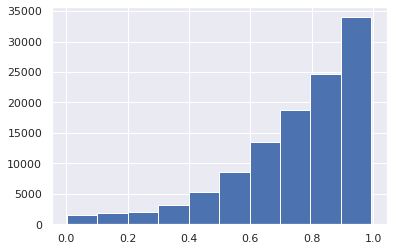

In [22]:
plt.hist(preds_proba[:,1])
plt.show()

# Submissions

In [30]:
# Preparando os dados de teste
new_teste = teste.drop(['ID','target'], axis=1)
new_teste.shape

(114393, 181)

In [31]:
new_teste.head()

,grp_1,grp_10,grp_11,grp_12,grp_2,grp_3,grp_4,grp_5,grp_6,grp_7,grp_8,grp_9,ica_1,ica_10,ica_11,ica_12,ica_2,ica_3,ica_4,ica_5,ica_6,ica_7,ica_8,ica_9,pca_1,pca_10,pca_11,pca_12,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,srp_1,srp_10,srp_11,srp_12,srp_2,srp_3,srp_4,srp_5,srp_6,srp_7,srp_8,srp_9,tsvd_1,tsvd_10,tsvd_11,tsvd_12,tsvd_2,tsvd_3,tsvd_4,tsvd_5,tsvd_6,tsvd_7,tsvd_8,tsvd_9,v1,v10,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v11,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119 v123,v119 v48,v119 v85,v119^2,v119_x,v119_y,v120,v121,v122,v123 v48,v123 v85,v123^2,v123_x,v123_y,v124,v125,v126,v127,v129,v130,v131,v14,v15,v16,v17,v18,v19,v2,v20,v21,v22,v23,v24,v26,v27,v28,v29,v3,v30,v31,v35,v36,v37,v39,v4,v40,v42,v44,v45,v47,v48 v85,v48^2,v48_x,v48_y,v5,v50,v51,v52,v56,v57,v58,v59,v6,v61,v62 v119,v62 v123,v62 v48,v62 v85,v62^2,v62_x,v62_y,v66,v68,v69,v7,v70,v71,v72,v74,v75,v78,v79,v80,v81,v82,v84,v85^2,v85_x,v85_y,v86,v88,v9,v90,v91,v92,v93,v94,v98,v99
0,0.2219,-0.4870,0.5280,-0.1092,1.0520,0.0393,0.6144,0.3852,-0.3299,-0.8915,-0.5185,0.8387,1.2173,-0.1974,1.2320,1.3797,0.7280,0.5167,0.9107,-0.2035,0.1263,-0.0185,-0.2569,0.1022,-0.4262,-1.0995,0.2572,-0.7298,0.4958,-0.3688,1.3596,-0.2332,1.3436,0.4925,-0.4139,0.4085,0.2530,0.6415,-0.2151,-0.4978,-0.3759,-0.3095,0.3324,0.0617,-1.7216,-1.4236,-0.3268,0.1646,-0.2645,-0.0647,1.0482,-0.0673,-0.5532,-0.1102,-0.1387,-1.3907,-0.2398,1.4558,0.4947,-0.6021,-0.2247,-0.4080,1.2406,-1.4525,-0.6013,-1.1770,-1.3184,-0.4112,-0.1012,1,-0.8249,-0.5534,2.3378,0,0.2788,20,37,-0.5075,0.6389,-1.9527,-1.2421,-1.6088,-0.3782,-0.6213,-0.4859,-0.3233,-0.7362,-0.7365,0.4122,0.6380,0.6143,-0.5341,-0.5326,-0.3966,-0.6938,-0.6941,-0.3587,6,-0.9359,0.6382,0,0.5826,-0.2845,0.0926,-0.4875,-1.5381,-0.1483,-1.4801,0.1082,1.8417,0.0254,0.3796,3924,-0.2008,4,-2.1535,2.6803,-2.2302,-1.3004,2,7,0,0.0802,-0.7503,0.3349,1.0757,0.0358,0.4063,-2.7724,-0.1079,0.1762,9,-0.6087,0.1068,0.1744,0.1746,-1.3740,-1.1888,0.7570,2,6,-2.8933,-1.2102,-0.9749,-0.7708,0.0723,-0.5765,-0.4599,-0.0175,-0.4173,-0.2488,1,-0.0441,0,-1.1043,-0.6356,-1.5421,-0.6485,5,1,1,3,1.7178,16,-0.3133,0.9032,1.1789,-0.8934,-0.6436,-0.8046,-0.8076,-5.8953,-0.0882,0.3294,0.1441,1,0.4624,-0.3778,-1.2591,1.3352,-1.2326
1,0.2589,-0.3141,0.3359,-0.1635,0.1370,-0.2818,0.1658,0.3323,0.1300,-0.2200,-0.1345,0.0335,-0.1729,0.4665,0.1471,-0.1169,-0.0002,-1.1202,0.2434,-0.1855,0.1309,-0.1232,0.2399,0.0454,-0.2616,0.2824,-0.3857,0.0061,0.1697,-0.0064,0.0395,0.0051,0.1018,0.0919,1.0173,-0.5899,0.3268,-0.9711,-0.3140,-0.2472,-0.2911,-0.2154,0.2233,0.2570,0.1109,-0.8912,-0.2752,-0.0241,-0.2107,-0.3043,-0.4601,-0.1983,-0.2926,0.0733,-0.0961,-0.0655,0.0067,0.1248,0.0922,1.1290,-0.1178,-0.4237,0.2498,-0.0783,-0.1714,-0.1046,-0.1129,-0.2765,0.0751,3,-0.1478,-0.2248,0.0404,1,-0.1324,4,37,1.0366,-0.0246,-0.0742,-0.0603,-0.0828,-0.2648,-0.2859,-0.2808,-0.2816,-0.2913,-0.2905,-0.1473,-0.1625,-0.0288,-0.2309,-0.2467,-0.2425,-0.2293,-0.2284,-0.2743,72,-0.0879,-0.1219,0,-0.2133,-0.1026,-0.9255,-0.0955,0.0027,-0.1072,-0.0705,-0.1082,-0.1215,0.1709,-1.0713,9043,-0.2008,3,-0.0718,-0.0618,-0.0130,0.0566,2,0,0,-0.0310,0.1168,-0.1402,-0.2668,0.0382,-1.1762,0.0117,-0.0072,0.0013,2,-0.1530,-0.1076,-0.0445,-0.0454,-0.0372,-0.4104,-0.0191,0,90,-0.0112,-0.2524,-0.0293,-0.0335,0.1727,-0.2475,-0.1787,-0.0583,-0.0950,-0.2488,1,-0.0441,2,0.2246,0.0239,-0.0417,0.0732,5,5,1,3,-0.0027,4,-0.0819,0.0833,-0.4745,-0.1465,-0.2280,-0.1268,-0.1173,-0.1038,-0.1125,0.0186,0.0055,2,-0.1130,-0.0807,-0.0963,-0.0099,-0.0240
2,0.2626,-0.7057,0.7201,0.0251,0.6963,0.0742,1.0837,0.4115,0.3728,-0.6472,-0.3982,0.8326,1.9721,-0.2155,1.1702,1.5814,0.7983,-0.7965,0.6947,0.1536,0.2603,0.0418,-0.4662,0.1516,-0.4188,-1.6494,0.7195,-1.1499,0.5027,-0.2830,1.3508,-0.2131,1.3567,0.3827,0.9531,0.2337,0.2478,-2.0225,-0.1756,-0.4873,-0.4330,-0.2634,0.2925,0.0984,-2.1366,-1.8260,-0.3287,-0.3151,-0.2585,-0.0633,1.9031,0.0110,-0.5452,-0.0352,-0.1007,-1.3771,-0.2199,1.4728,0.3852,0.7393,-1.9154,-0.2199,1.2579,-0.1245,-1.40

In [32]:
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = model.predict_proba(new_teste)[:,1]
print(submission.shape)
submission.head()

(114393, 2)


,ID,PredictedProb
0,0,0.2664
1,1,0.8818
2,2,0.8459
3,7,0.6482
4,10,0.7749


In [33]:
submission.to_csv('../submission/submission_cat_v.1.0.2.csv', index=False)

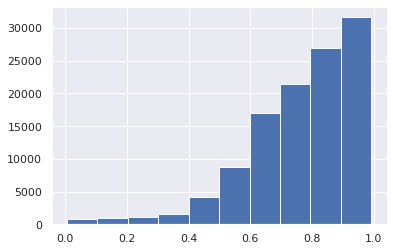

In [34]:
plt.hist(submission.PredictedProb)
plt.show()